# Building a complex query for MSMARCO Document

In this example, we'll walk through the process of building a more complete and complex query for the MSMARCO Document dataset. This assumes that you are familiar with optimizing a basic query as shown in the "Field Weights" notebook. We'll be using that query and the optimal weights found there as the foundation on which we build a more complex query.

As with the previous notebook and in accordance with the MSMARCO Document ranking task, we'll continue to use MRR@100 on the `dev` dataset for evaluation and comparison with other approaches.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100, optimize_bm25_mrr100
from qopt.optimize import Config, set_bm25_parameters

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://34.89.254.129:9200')

## Starting point

Let's quickly review the steps we made in the "Field Weights" notebook. We first used a `multi_match` `cross_fields` query which searches for terms across the `url`, `title` and `body` fields of our documents. Using the default fields weights of `1.0` on those three fields, we get the following MRR@100.

In [6]:
%%time

results = evaluate_mrr100_dev(es,
    template_id='cross_fields',
    params={
        'url|weight': 1.0,
        'title|weight': 1.0,
        'body|weight': 1.0,
    })

Score: 0.2484
CPU times: user 2.71 s, sys: 1.58 s, total: 4.29 s
Wall time: 1min 43s


Next we found the following field weight parameters to be optimal and improved on the baseline MRR@100:

In [5]:
%%time

results = evaluate_mrr100_dev(es,
    template_id='cross_fields',
    params={
          'url|weight': 10.0,
          'title|weight': 10.0,
          'body|weight': 5.17,
    })

Score: 0.2626
CPU times: user 2.15 s, sys: 508 ms, total: 2.66 s
Wall time: 2min 18s


## BM25 parameters: cross_fields

In [5]:
%%time

best_score_a, best_params_a, final_params_a, metadata_a = optimize_bm25_mrr100(es,
    template_id='cross_fields',
    default_params={
        'url|weight': 1.0,
        'title|weight': 1.0,
        'body|weight': 1.0,
    },
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2359 with: {'k1': 3.0745326497881753, 'b': 0.6367760518234173}
 - iteration 2 scored 0.2180 with: {'k1': 1.437906491461255, 'b': 0.48676844293971505}
 - iteration 3 scored 0.2414 with: {'k1': 2.354265603123957, 'b': 0.9694307966788158}
 - iteration 4 scored 0.2119 with: {'k1': 0.5156770657411466, 'b': 0.6878592720385004}
 - iteration 5 scored 0.2386 with: {'k1': 1.7714102170517205, 'b': 0.7345377865488472}
 - iteration 6 scored 0.2099 with: {'k1': 2.579562513328887, 'b': 0.3832214531924588}
 - iteration 7 scored 0.2076 with: {'k1': 0.5283983599012858, 'b': 0.5873396109981275}
 - iteration 8 scored 0.2291 with: {'k1': 3.046080659295053, 'b': 0.5539684177125992}
 - iteration 9 scored 0.2187 with: {'k1': 2.7494778113942875, 'b': 0.4510881112084779}
 - iteration 10 scored 0.2424 with: {'k1': 3.7631414066990168, 'b': 0.9824326542490145}
 - iteration 11 scored 0.2436 with: {'k1': 3.999309154667108, 'b': 0.7783799111324012}
 - iteration 12 scored 

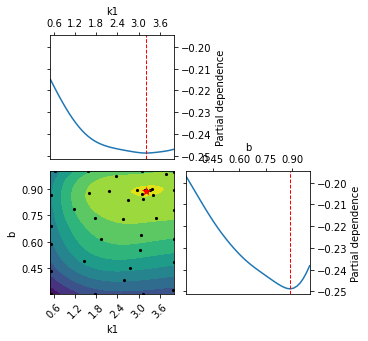

In [6]:
_ = plot_objective(metadata_a, sample_source='result')

In [7]:
%%time

set_bm25_parameters(es, 'msmarco-document', **best_params_a)
results = evaluate_mrr100_dev(es, template_id='cross_fields', params=final_params_a)

Score: 0.2629
CPU times: user 2.31 s, sys: 612 ms, total: 2.92 s
Wall time: 46.8 s


## BM25 parameters: best_fields

In [8]:
%%time

best_score_0, best_params_0, final_params_0, metadata_0 = optimize_bm25_mrr100(es,
    template_id='best_fields',
    default_params={
        'url|weight': 1.0,
        'title|weight': 1.0,
        'body|weight': 1.0,
        'operator': 'OR',
        'minimum_should_match': '1',
    },
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2422 with: {'k1': 3.3532630652384965, 'b': 0.7312048765814982}
 - iteration 2 scored 0.2463 with: {'k1': 1.9167231434226601, 'b': 0.6838397619151227}
 - iteration 3 scored 0.2611 with: {'k1': 0.9794155724438198, 'b': 0.9767772571016957}
 - iteration 4 scored 0.2553 with: {'k1': 1.834707176756085, 'b': 0.8206718012795733}
 - iteration 5 scored 0.2408 with: {'k1': 1.915719744680421, 'b': 0.6007166027107171}
 - iteration 6 scored 0.2444 with: {'k1': 0.7472705400825247, 'b': 0.541315419337441}
 - iteration 7 scored 0.2576 with: {'k1': 0.6833953752864663, 'b': 0.8453494163122925}
 - iteration 8 scored 0.2353 with: {'k1': 1.8333216927850517, 'b': 0.5416550134235754}
 - iteration 9 scored 0.2548 with: {'k1': 0.5627359156658823, 'b': 0.9612832259289152}
 - iteration 10 scored 0.2281 with: {'k1': 2.4879943372200706, 'b': 0.5100240684971907}
 - iteration 11 scored 0.2466 with: {'k1': 2.7483909852887245, 'b': 1.0}
 - iteration 12 scored 0.2398 with: {

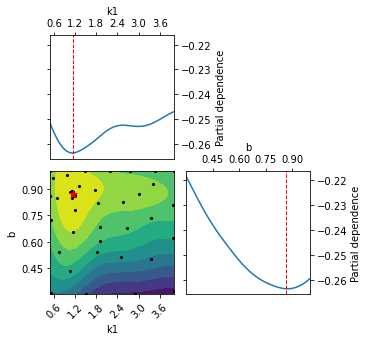

In [9]:
_ = plot_objective(metadata_0, sample_source='result')

In [10]:
%%time

# set_bm25_parameters(es, 'msmarco-document', **{'k1': 1.2, 'b': 0.75})

set_bm25_parameters(es, 'msmarco-document', **best_params_0)
results = evaluate_mrr100_dev(es, template_id='best_fields', params=final_params_0)

Score: 0.2829
CPU times: user 2.42 s, sys: 1.02 s, total: 3.44 s
Wall time: 36.5 s


In [12]:
%%time

# best_fields with BM25 params from cross_fields

set_bm25_parameters(es, 'msmarco-document', **best_params_a)
results = evaluate_mrr100_dev(es, template_id='best_fields', params=final_params_0)

Score: 0.2655
CPU times: user 2.27 s, sys: 837 ms, total: 3.11 s
Wall time: 45.8 s


In [13]:
%%time

# cross_fields with BM25 params from best_fields

set_bm25_parameters(es, 'msmarco-document', **best_params_0)
results = evaluate_mrr100_dev(es, template_id='cross_fields', params=final_params_a)

Score: 0.2475
CPU times: user 2.57 s, sys: 899 ms, total: 3.47 s
Wall time: 42.8 s


## Alternative query: best_fields

The first query type we used was a `multi_match` `cross_fields` query. This searches for query terms individually across each of the three document fields. For example, given a query string "impact of the success of the manhattan project", we search for each of the query terms in each of the fields. So we could have "impact" matching the body only, while "manhattan" could match all three fields. Due to the nature of the queries which are all questions, this might not be the best query type to use.

In this step, we're going to try using the `best_fields` variant of the `multi_match` query. This variant will look across fields but will only return the field and score with the best matches. We will also experiment in this query with modifying a few parameters of the query that are sometimes hard to guess at. Specifically, we'll explore which `operator` parameter is best (`OR`, `AND`) and what the minimum number of matching terms per field should be using `minimum_should_match`. As you can guess, this is now a much bigger parameter space than the previous example, so it's even more important that we use an optimization method that is a big smarter than just a grid search.

Here's the baseline query with default parameter values.

In [10]:
%%time

results = evaluate_mrr100_dev(es,
    template_id='best_fields',
    params={
        'url|weight': 1.0,
        'title|weight': 1.0,
        'body|weight': 1.0,
        'operator': 'OR',
        'minimum_should_match': '1',
    })

Score: 0.2799
CPU times: user 2.3 s, sys: 472 ms, total: 2.77 s
Wall time: 29.3 s


That's pretty impressive for the baseline query and even beats our optimized `cross_fields`.

Let's try and optimize this now. Looking at the parameters, it's actually a pretty complex and large parameters space to try and optimize all at once, so let's try breaking this into two steps to see if we can get some more traction.

First we'll optimize the field weights, and then we'll select the `operator` and `minimum_should_match` parameters in a step after that.

In [24]:
%%time

best_score_1, best_params_1, final_params_1, metadata_1 = optimize_query_mrr100(es,
    template_id='best_fields',
    config_space=Config.parse({
        'num_iterations': 50,
        'num_initial_points': 10,
        'space': {
            'url|weight': { 'low': 0.0, 'high': 10.0 },
            'title|weight': { 'low': 0.0, 'high': 10.0 },
            'body|weight': { 'low': 0.0, 'high': 10.0 },
        },
        'default': {
            'operator': 'OR',
            'minimum_should_match': '1'
        }
    }),
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2248 with: {'url|weight': 3.1343275920195506, 'title|weight': 2.0455766407526292, 'body|weight': 3.988610729048018}
 - iteration 2 scored 0.2216 with: {'url|weight': 3.447148412216394, 'title|weight': 2.6569555509116376, 'body|weight': 9.594735682992612}
 - iteration 3 scored 0.2411 with: {'url|weight': 4.904752948066944, 'title|weight': 5.489906983930832, 'body|weight': 5.567540784194106}
 - iteration 4 scored 0.2376 with: {'url|weight': 5.8499481215351965, 'title|weight': 8.390865010326008, 'body|weight': 9.274098114633116}
 - iteration 5 scored 0.1365 with: {'url|weight': 7.085249845407454, 'title|weight': 1.8612314899667517, 'body|weight': 1.8204040629577103}
 - iteration 6 scored 0.2159 with: {'url|weight': 6.370189615304595, 'title|weight': 6.803935422294797, 'body|weight': 0.08949162457882133}
 - iteration 7 scored 0.2107 with: {'url|weight': 8.67442316354557, 'title|weight': 8.344380690775235, 'body|weight': 0.6267412924962491}
 - i

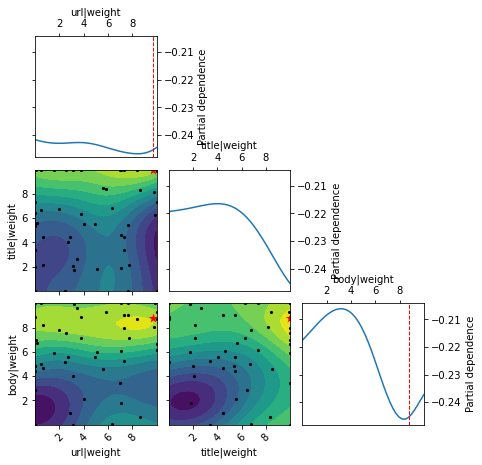

In [26]:
_ = plot_objective(metadata_1, sample_source='result')

Interesting that the best weights are almost equal across the fields. This starts to explain how the baseline query with all weights equal was so good. Let's run the evaluation with just the tuned weights to see how much we improve over the baseline.

In [28]:
%%time

results = evaluate_mrr100_dev(es, template_id='best_fields', params=final_params_1)

Score: 0.2865
CPU times: user 2.33 s, sys: 1.25 s, total: 3.58 s
Wall time: 1min 18s


Ok, so we have some progress, albeit not very much. Let's continue and try optimizing the last parameters of this query to see if we get a bigger boost.

We can now take the best parameters found for the field weights, set them as constants or `default` values for the template, and just focus the next optimization on picking the last parameters.

Since we have a pretty small search space with just a few possible values per pameter, if we just give sequences, the optimizer will actually choose a grid search here and test every possible combination of the two parameters.

In [35]:
%%time

best_score_2, best_params_2, final_params_2, metadata_2 = optimize_query_mrr100(es,
    template_id='best_fields',
    config_space=Config.parse({
        'num_iterations': 50,
        'num_initial_points': 10,
        'space': {
            'operator': ['OR', 'AND'],
            'minimum_should_match': [1, 2, 3, 4, 5],
        },
        'default': best_params_1
    }),
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2494 with: {'minimum_should_match': 1, 'operator': 'OR'}
 - iteration 2 scored 0.0000 with: {'minimum_should_match': 1, 'operator': 'AND'}
 - iteration 3 scored 0.2354 with: {'minimum_should_match': 2, 'operator': 'OR'}
 - iteration 4 scored 0.0000 with: {'minimum_should_match': 2, 'operator': 'AND'}
 - iteration 5 scored 0.1981 with: {'minimum_should_match': 3, 'operator': 'OR'}
 - iteration 6 scored 0.0000 with: {'minimum_should_match': 3, 'operator': 'AND'}
 - iteration 7 scored 0.1389 with: {'minimum_should_match': 4, 'operator': 'OR'}
 - iteration 8 scored 0.0000 with: {'minimum_should_match': 4, 'operator': 'AND'}
 - iteration 9 scored 0.0828 with: {'minimum_should_match': 5, 'operator': 'OR'}
 - iteration 10 scored 0.0000 with: {'minimum_should_match': 5, 'operator': 'AND'}
Best score: 0.2494
Best params: {'minimum_should_match': 1, 'operator': 'OR'}
Final params: {'url|weight': 9.682062830345467, 'title|weight': 10.0, 'body|weight':

Even after trying a bunch of options, it turns out that the defaults for `operator` and `minimum_should_match` are actually the best! Even though we didn't find better values, we did learn something in the process.

We now don't need to do another evaluation since there was no change after tuning these last two operators.

## Combining queries

We've seen the process to optimize field weights on two different `multi_match` queries but it would be interesting to see if combining them with in a parent `bool` query might actually result in even better MRR@100. Let's give it a shot and find out.

We'll combine the two queries by using a `bool` query with a `should` clause. That means that we don't require both queries to match documents, but we will combine the scores when they do. Using the `combined` template, we can use the previously discovered optimal field weights, and add some new parameters for query `boost`s to decide how we should combine these two queries.

Side note: Combining queries in this way may improve relevance as measured by MRR@100, but it will hurt performance and the query times will be quite a lot higher than with a single, simpler query. Keep this in mind when building complex queries for production!

Here's the baselines that we'll compare against when trying to combine these queries in an optimal way. First a combined query with all parameters default values, and second a combined query using the optimal field weights previously found.

In [57]:
%%time

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # default weights
        'multi_match|cross_fields|url|weight': 1.0,
        'multi_match|cross_fields|title|weight': 1.0,
        'multi_match|cross_fields|body|weight': 1.0,
        'multi_match|best_fields|url|weight': 1.0,
        'multi_match|best_fields|title|weight': 1.0,
        'multi_match|best_fields|body|weight': 1.0,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.2798
CPU times: user 5.01 s, sys: 1.66 s, total: 6.66 s
Wall time: 6min 52s


Not bad, but I think we can do better by using the optimal field weights.

In [16]:
%%time

# BM25 params from default ES
set_bm25_parameters(es, 'msmarco-document', **{'k1': 1.2, 'b': 0.75})

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # optimal weights
        'multi_match|cross_fields|url|weight': 10.0,
        'multi_match|cross_fields|title|weight': 10.0,
        'multi_match|cross_fields|body|weight': 5.17,
        'multi_match|best_fields|url|weight': 9.682,
        'multi_match|best_fields|title|weight': 10.0,
        'multi_match|best_fields|body|weight': 8.746,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.3027
CPU times: user 4.77 s, sys: 1.62 s, total: 6.4 s
Wall time: 6min 8s


In [15]:
%%time

# BM25 params from cross_fields
set_bm25_parameters(es, 'msmarco-document', **best_params_a)

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # optimal weights
        'multi_match|cross_fields|url|weight': 10.0,
        'multi_match|cross_fields|title|weight': 10.0,
        'multi_match|cross_fields|body|weight': 5.17,
        'multi_match|best_fields|url|weight': 9.682,
        'multi_match|best_fields|title|weight': 10.0,
        'multi_match|best_fields|body|weight': 8.746,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.2728
CPU times: user 3.79 s, sys: 1.01 s, total: 4.79 s
Wall time: 6min 21s


In [14]:
%%time

# BM25 params from best_fields
set_bm25_parameters(es, 'msmarco-document', **best_params_0)

results = evaluate_mrr100_dev(es,
    template_id='combined',
    params={
        # optimal weights
        'multi_match|cross_fields|url|weight': 10.0,
        'multi_match|cross_fields|title|weight': 10.0,
        'multi_match|cross_fields|body|weight': 5.17,
        'multi_match|best_fields|url|weight': 9.682,
        'multi_match|best_fields|title|weight': 10.0,
        'multi_match|best_fields|body|weight': 8.746,
        # default boosts
        'multi_match|cross_fields|boost': 1.0,
        'multi_match|best_fields|boost': 1.0,
    })

Score: 0.3011
CPU times: user 4.25 s, sys: 1.36 s, total: 5.61 s
Wall time: 5min 32s


That's already quite a better than either the `cross_fields` or `best_fields` queries on their own.

As before, let's continue and see if there is an improvement by tuning the boosts on each query. We've got a smaller parameter space to search over, so we'll specify running fewer iterations than before since these queries run a lot slower.

In [69]:
%%time

best_score_3, best_params_3, final_params_3, metadata_3 = optimize_query_mrr100(es,
    template_id='combined',
    config_space=Config.parse({
        'num_iterations': 30,
        'num_initial_points': 5,
        'space': {
            'multi_match|cross_fields|boost': { 'low': 0.0, 'high': 5.0 },
            'multi_match|best_fields|boost': { 'low': 0.0, 'high': 5.0 },
        },
        'default': {
            'multi_match|cross_fields|url|weight': 10.0,
            'multi_match|cross_fields|title|weight': 10.0,
            'multi_match|cross_fields|body|weight': 5.17,
            'multi_match|best_fields|url|weight': 9.682,
            'multi_match|best_fields|title|weight': 10.0,
            'multi_match|best_fields|body|weight': 8.746,
        },
    }),
    verbose=True)

Optimizing parameters
 - iteration 1 scored 0.2725 with: {'multi_match|cross_fields|boost': 2.547577325223018, 'multi_match|best_fields|boost': 0.5471916531942151}
 - iteration 2 scored 0.2694 with: {'multi_match|cross_fields|boost': 2.6798639019055748, 'multi_match|best_fields|boost': 1.633720712857639}
 - iteration 3 scored 0.2683 with: {'multi_match|cross_fields|boost': 3.2768751918169867, 'multi_match|best_fields|boost': 3.2879218237613235}
 - iteration 4 scored 0.2551 with: {'multi_match|cross_fields|boost': 0.7909425127149035, 'multi_match|best_fields|boost': 4.947870579130785}
 - iteration 5 scored 0.2697 with: {'multi_match|cross_fields|boost': 2.8534793222286603, 'multi_match|best_fields|boost': 1.4987177123346775}
 - iteration 6 scored 0.2517 with: {'multi_match|cross_fields|boost': 5.0, 'multi_match|best_fields|boost': 0.0}
 - iteration 7 scored 0.2517 with: {'multi_match|cross_fields|boost': 1.3248474705567896, 'multi_match|best_fields|boost': 0.0}
 - iteration 8 scored 0.2

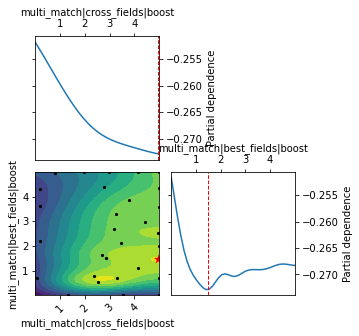

In [70]:
_ = plot_objective(metadata_3, sample_source='result')

In [71]:
%%time

results = evaluate_mrr100_dev(es, template_id='combined', params=final_params_3)

Score: 0.2930
CPU times: user 3.76 s, sys: 1.85 s, total: 5.62 s
Wall time: 13min 24s


So that's kind of odd. We couldn't actually find boost parameters that were better than the defaults `1.0`. I wonder what's going on here. Let's break this down and see if we can figure it out.

The first thing to note 

In [65]:
def collect_scores_cross_fields(query_string):
    res = es.search(index='msmarco-document', size=100, body={ "query": {
        "multi_match": {
            "type": "cross_fields",
            "query": query_string,
            "fields": [
                "url^10.0",
                "title^10.0",
               "body^5.17"
            ],
            "operator": "OR",
            "boost": "1.0"
      }
    }})
    return [hit['_score'] for hit in res['hits']['hits']]

def collect_scores_best_fields(query_string):
    res = es.search(index='msmarco-document', size=100, body={ "query": {
        "multi_match": {
            "type": "best_fields",
            "query": query_string,
            "fields": [
                "url^9.682",
                "title^10.0",
               "body^8.746"
            ],
            "operator": "OR",
            "boost": "1.0"
      }
    }})
    return [hit['_score'] for hit in res['hits']['hits']]

def collect_scores(queries):
    cross_field_scores = []
    best_field_scores = []

    for query in list(queries):
        cfs = collect_scores_cross_fields(query[1])
        bfs = collect_scores_best_fields(query[1])
        
        # keep just n scores to make sure the lists are the same length
        length = min(len(cfs), len(bfs))
        cross_field_scores.append(cfs[:length])
        best_field_scores.append(bfs[:length])

    return cross_field_scores, best_field_scores

In [66]:
from qopt.trec import load_queries_as_tuple
from qopt.notebooks import ROOT_DIR

queries = load_queries_as_tuple(os.path.join(ROOT_DIR, 'data', 'msmarco-document-sampled-queries.1000.tsv'))
cfs, bfs = collect_scores(queries)

In [67]:
from itertools import chain

cfs_flat = list(chain(*cfs))
bfs_flat = list(chain(*bfs))

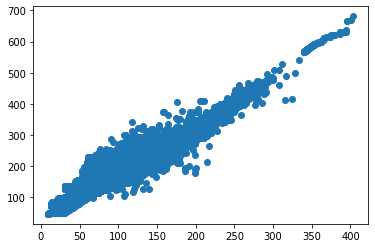

In [68]:
import matplotlib.pyplot as plt
plt.scatter(cfs_flat, bfs_flat)
plt.show()